In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import main

In [20]:
## Start of Notebook

print('Starting Assignment 1')
RawData = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
print(RawData.shape)
print(RawData.describe())


Starting Assignment 1
(111993, 12)
            Instance  Year of Record            Age  Size of City  \
count  111993.000000   111552.000000  111499.000000  1.119930e+05   
mean    55997.000000     1999.421274      37.345304  8.388538e+05   
std     32329.738686       11.576382      16.036694  2.196879e+06   
min         1.000000     1980.000000      14.000000  7.700000e+01   
25%     27999.000000     1989.000000      24.000000  7.273400e+04   
50%     55997.000000     1999.000000      35.000000  5.060920e+05   
75%     83995.000000     2009.000000      48.000000  1.184501e+06   
max    111993.000000     2019.000000     115.000000  4.999251e+07   

       Wears Glasses  Body Height [cm]  Income in EUR  
count  111993.000000     111993.000000   1.119930e+05  
mean        0.500531        175.220192   1.092138e+05  
std         0.500002         19.913889   1.498024e+05  
min         0.000000         94.000000  -5.696906e+03  
25%         0.000000        160.000000   3.077169e+04  
50%    

In [21]:
## Dropping Features that are missing a large amount of data
## Dropping instances with missing data

RawData = main.HandleMissingData(RawData)

null_counts = RawData.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

37
1999.4212743832472
Number of null values in each column:
Year of Record       0
Gender               0
Age                  0
Country              0
Size of City         0
Profession           0
University Degree    0
Wears Glasses        0
Body Height [cm]     0
Income in EUR        0
dtype: int64


In [80]:
## Scale data
columns = RawData.columns.values
RawData= RawData.drop(columns=['Country','Profession','Gender','University Degree'], axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(RawData)
rescaledData = scaler.transform(RawData)

## Holded scaled for later.
df = pd.DataFrame(rescaledData)
print(df)

               0         1         2    3         4         5
0       0.435897  0.267327  0.024801  0.0  0.578947  0.012612
1       0.410256  0.267327  0.032073  0.0  0.538012  0.018276
2       0.974359  0.138614  0.025963  1.0  0.444444  0.030936
3       0.666667  0.188119  0.015039  1.0  0.450292  0.009770
4       0.769231  0.316832  0.001907  0.0  0.549708  0.008263
...          ...       ...       ...  ...       ...       ...
111988  0.000000  0.148515  0.004105  0.0  0.239766  0.004325
111989  0.666667  0.217822  0.020258  1.0  0.309942  0.023531
111990  0.333333  0.217822  0.001216  1.0  0.345029  0.055878
111991  1.000000  0.396040  0.016974  0.0  0.561404  0.019986
111992  0.948718  0.128713  0.006511  0.0  0.467836  0.028650

[111993 rows x 6 columns]
        Year of Record       Age  Size of City  Wears Glasses  \
0             0.435897  0.267327      0.024801              0   
1             0.410256  0.267327      0.032073              0   
2             0.974359  0.138614  

In [5]:
## Removing Outliers. Outliers being top and bottoms 2.5%

from scipy import stats
import numpy as np

z = np.abs(stats.zscore(RawData['Income in EUR']))
print(z)
print(z.shape)
count = []
index = []
for i in range(len(z)):
    if z[i] > 3:
        count.append(z[i])
        index.append(i)
        
RawData = RawData.drop(index)
print("Removing " + str(len(index)))
print("New Number of Instances: " + str(RawData.shape))

[0.32163766 0.12157727 0.32555287 ... 1.20651194 0.06119611 0.24480686]
(111993,)
Removing 2399
New Number of Instances: (109594, 10)


In [22]:
## Seeing the data and the unique values

for s in RawData.columns.values:
    print("Features in " + s)
    print(RawData[s].unique())
    print(len(RawData[s].unique()))


Features in Year of Record
[1997. 1996. 2018. 2006. 2010. 1991. 1982. 2008. 2015. 2019. 1981. 1989.
 2003. 1987. 1995. 1992. 1980. 1983. 2011. 2014. 1985. 2005. 1998. 2001.
 2017. 2007. 1988. 1994. 2012. 2009. 2013. 2004. 1999. 2002. 1993. 2000.
 1990. 2016. 1986. 1984.]
40
Features in Gender
['0' 'other' 'female' 'male' 'unknown']
5
Features in Age
[ 41.  28.  33.  46.  60.  71.  36.  43.  16.  51.  15.  22.  32.  40.
  31.  27.  25.  35.  63.  38.  34.  20.  23.  14.  37.  62.  52.  47.
  24.  26.  50.  49.  18.  19.  39.  66.  21.  44.  29.  64.  65.  53.
  78.  42.  58.  17.  30.  79.  48.  56.  83.  54.  74.  87.  90.  67.
  45.  77.  73.  55.  92.  80.  72.  57.  70.  59.  61.  82.  69.  98.
  94.  68.  81.  97.  76.  75.  88.  91.  96.  84.  89. 107.  85.  86.
 100. 110.  95.  99.  93. 104. 102. 101. 105. 111. 108. 103. 109. 106.
 115.]
99
Features in Country
['Belarus' 'Singapore' 'Norway' 'Cuba' 'United Arab Emirates' 'Liberia'
 'State of Palestine' 'Israel' 'South Sudan' 'Kyr

In [23]:
## Section to conver to binary matrix
## Changing Country, Profession

RawData_Country = pd.get_dummies(RawData.Country)
print(type(RawData_Country))
RawData_Profession = pd.get_dummies(RawData.Profession)
print(type(RawData_Profession))
RawData_Gender = pd.get_dummies(RawData['Gender'])
print(RawData_Gender.describe())
RawData_Uni = pd.get_dummies(RawData['University Degree'])
print(RawData_Uni.describe())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                   0         female           male          other  \
count  111993.000000  111993.000000  111993.000000  111993.000000   
mean        0.006465       0.242604       0.381792       0.241622   
std         0.080143       0.428660       0.485828       0.428068   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             unknown  
count  111993.000000  
mean        0.127517  
std         0.333553  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
                   0       Bachelor         Master             No  \
count  111993.000000  1119

In [24]:
RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR
count,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,1.119930e+05
mean,1999.419616,37.343780,8.388538e+05,0.500531,175.220192,1.092138e+05
std,11.553597,16.001302,2.196879e+06,0.500002,19.913889,1.498024e+05
min,1980.000000,14.000000,7.700000e+01,0.000000,94.000000,-5.696906e+03
25%,1989.000000,24.000000,7.273400e+04,0.000000,160.000000,3.077169e+04
50%,1999.000000,35.000000,5.060920e+05,1.000000,174.000000,5.733917e+04
75%,2009.000000,48.000000,1.184501e+06,1.000000,190.000000,1.260936e+05
max,2019.000000,115.000000,4.999251e+07,1.000000,265.000000,5.285252e+06


In [25]:
## Creating clean training data
print(RawData.columns)

RawData = pd.concat([RawData, RawData_Country], axis=1)
RawData= RawData.drop('Country', axis=1)
RawData = pd.concat([RawData, RawData_Profession], axis=1)
RawData= RawData.drop('Profession', axis=1)
RawData = pd.concat([RawData, RawData_Gender], axis=1)
RawData= RawData.drop('Gender', axis=1)
RawData = pd.concat([RawData, RawData_Uni], axis=1)
RawData= RawData.drop('University Degree', axis=1)

Index(['Year of Record', 'Gender', 'Age', 'Country', 'Size of City',
       'Profession', 'University Degree', 'Wears Glasses', 'Body Height [cm]',
       'Income in EUR'],
      dtype='object')


In [27]:
RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,0,female,male,other,unknown,0,Bachelor,Master,No,PhD
count,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,111993.000000,111993.000000,...,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000
mean,1999.419616,37.343780,8.388538e+05,0.500531,175.220192,1.092138e+05,0.000196,0.003554,0.000063,0.000473,...,0.006465,0.242604,0.381792,0.241622,0.127517,0.006224,0.385488,0.240560,0.306823,0.060906
std,11.553597,16.001302,2.196879e+06,0.500002,19.913889,1.498024e+05,0.014014,0.059508,0.007906,0.021749,...,0.080143,0.428660,0.485828,0.428068,0.333553,0.078644,0.486713,0.427425,0.461177,0.239158
min,1980.000000,14.000000,7.700000e+01,0.000000,94.000000,-5.696906e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,24.000000,7.273400e+04,0.000000,160.000000,3.077169e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1999.000000,35.000000,5.060920e+05,1.000000,174.000000,5.733917e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2009.000000,48.000000,1.184501e+06,1.000000,190.000000,1.260936e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,2019.000000,115.000000,4.999251e+07,1.000000,265.000000,5.285252e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
RawData['Year of Record'] = df[0]
RawData['Age'] = df[1]
RawData['Size of City'] = df[2]
RawData['Body Height [cm]'] = df[4]

RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,0,female,male,other,unknown,0,Bachelor,Master,No,PhD
count,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,111993.000000,111993.000000,...,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000
mean,0.497939,0.231127,0.016778,0.500531,0.474972,1.092138e+05,0.000196,0.003554,0.000063,0.000473,...,0.006465,0.242604,0.381792,0.241622,0.127517,0.006224,0.385488,0.240560,0.306823,0.060906
std,0.296246,0.158429,0.043944,0.500002,0.116455,1.498024e+05,0.014014,0.059508,0.007906,0.021749,...,0.080143,0.428660,0.485828,0.428068,0.333553,0.078644,0.486713,0.427425,0.461177,0.239158
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.696906e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230769,0.099010,0.001453,0.000000,0.385965,3.077169e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487179,0.207921,0.010122,1.000000,0.467836,5.733917e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.743590,0.336634,0.023692,1.000000,0.561404,1.260936e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.285252e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [103]:
RawData.head(10)

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,0,female,male,other,unknown,0,Bachelor,Master,No,PhD
0,0.435897,0.267327,0.024801,0,0.578947,61031.94416,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0.410256,0.267327,0.032073,0,0.538012,91001.32764,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.974359,0.138614,0.025963,1,0.444444,157982.17670,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.666667,0.188119,0.015039,1,0.450292,45993.75793,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.769231,0.316832,0.001907,0,0.549708,38022.16217,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
5,0.282051,0.455446,0.001120,0,0.508772,125809.99030,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6,0.051282,0.564356,0.024106,0,0.467836,150319.42260,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7,0.717949,0.217822,0.000627,0,0.561404,11849.02876,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
8,0.897436,0.287129,0.001705,0,0.555556,48058.20607,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9,1.000000,0.019802,0.026510,1,0.368421,90940.68912,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [28]:
## Output Training Data to new file
RawData.to_csv("../data/processedData3_1.csv", index=False)

In [136]:
## Read in new data and model

CleanData = main.ReadInData("../data/processedData7_normalised.csv")

In [137]:
CleanData.columns.unique

<bound method Index.unique of Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]', 'Income in EUR', 'Afghanistan', 'Albania',
       'Algeria', 'Angola',
       ...
       '0', 'female', 'male', 'other', 'unknown', '0.1', 'Bachelor', 'Master',
       'No.1', 'PhD'],
      dtype='object', length=1517)>

In [138]:
income = CleanData['Income in EUR']
# features = CleanData.drop(labels=['Income in EUR', 'Wears Glasses', 'Body Height [cm]'], axis=1)
features = CleanData.drop(labels=['Income in EUR'], axis=1)

features.head(5)

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Afghanistan,Albania,Algeria,Angola,Argentina,...,0,female,male,other,unknown,0.1,Bachelor,Master,No.1,PhD
0,0.435897,0.267327,0.024801,0,0.578947,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0.410256,0.267327,0.032073,0,0.538012,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0.974359,0.138614,0.025963,1,0.444444,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.666667,0.188119,0.015039,1,0.450292,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.769231,0.316832,0.001907,0,0.549708,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [139]:
count = 0
columnsToDrop = []
for i in range(5,features.shape[1] - 1):
    seriesAt = features.iloc[:,i].value_counts()
    posForSeries = seriesAt[1]
    if posForSeries < 5:
#         print(seriesAt.name)
        columnsToDrop.append(seriesAt.name)
        count = count + 1
        
print(len(columnsToDrop))

216


In [140]:
features = features.drop(columns=columnsToDrop)
print(features.head(5))

   Year of Record       Age  Size of City  Wears Glasses  Body Height [cm]  \
0        0.435897  0.267327      0.024801              0          0.578947   
1        0.410256  0.267327      0.032073              0          0.538012   
2        0.974359  0.138614      0.025963              1          0.444444   
3        0.666667  0.188119      0.015039              1          0.450292   
4        0.769231  0.316832      0.001907              0          0.549708   

   Afghanistan  Albania  Algeria  Angola  Argentina  ...  0  female  male  \
0            0        0        0       0          0  ...  1       0     0   
1            0        0        0       0          0  ...  0       0     0   
2            0        0        0       0          0  ...  0       0     0   
3            0        0        0       0          0  ...  0       0     0   
4            0        0        0       0          0  ...  0       1     0   

   other  unknown  0.1  Bachelor  Master  No.1  PhD  
0      0      

In [141]:
## Splitting Data

features_train, features_val, income_train, income_val = train_test_split(features, income, test_size=0.2, random_state=0)


In [142]:
## Using Linear Regression

model = LinearRegression()
model.fit(features_train, income_train)

print(model.coef_)
print(model.intercept_)

## Using Ridge Regression 
rig_model = RidgeCV()
rig_model.fit(features_train, income_train)

print(rig_model.coef_)
print(rig_model.intercept_)

# Using Random Forest Regression
# RFR = RandomForestRegressor(max_depth=200)
# RFR.fit(features_train, income_train)


[8.32774786e+04 1.75637004e+05 5.90360457e+04 ... 1.02001958e+18
 1.02001958e+18 1.02001958e+18]
-7.089309270348195e+17
[ 83294.29473652 175137.82726542  60456.36724449 ...  -1197.40078003
 -20129.45621962   8984.09416382]
820033.2541374158


In [143]:
## Predict with the validation data

income_predict = model.predict(features_val)
comparison = pd.DataFrame({'Actual': income_val, 'Predicted': income_predict})

comparison

income_predict_rig = rig_model.predict(features_val)

# income_predict_RFR = RFR.predict(features_val)

In [144]:
print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict)))

## Mean Absolute Error: 43557.00458896904
# Mean Squared Error: 7422065078.367375
# Root Mean Squared Error: 86151.40787223025

print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict_rig))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict_rig))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict_rig)))

# Mean Absolute Error: 42800.374852794565
# Mean Squared Error: 6624261842.145419
# Root Mean Squared Error: 81389.56838652863

## With Gender and University Degree
## STANDARD
# Mean Absolute Error: 42683.66765298456
# Mean Squared Error: 6611260404.6631155
# Root Mean Squared Error: 81309.65751165796

## RIDGE
# Mean Absolute Error: 42466.72095408424
# Mean Squared Error: 6546309166.8984585
# Root Mean Squared Error: 80909.26502507892

print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict_RFR))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict_RFR))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict_RFR)))

## Random Forest Regressor
# Mean Absolute Error: 34068.166948849575
# Mean Squared Error: 6755748786.367559
# Root Mean Squared Error: 82193.36217948236

## On attempt in remove outlier of Country and Professions
# Mean Absolute Error: 42537.31959067379
# Mean Squared Error: 6388705859.717933
# Root Mean Squared Error: 79929.38045373511
# Mean Absolute Error: 42541.744230243545
# Mean Squared Error: 6399195869.625069
# Root Mean Squared Error: 79994.97402727917

Mean Absolute Error: 42545.55430584182
Mean Squared Error: 6388120270.135478
Root Mean Squared Error: 79925.71720125806
Mean Absolute Error: 42541.44203742261
Mean Squared Error: 6399198478.961604
Root Mean Squared Error: 79994.99033665548
Mean Absolute Error: 33806.355939330104
Mean Squared Error: 6588521687.51917
Root Mean Squared Error: 81169.70917478496


In [ ]:
## Graphing Difference 

df1 = comparison.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
## Read in Test and try to map
## Cell used to explore difference in Train data and Test data

TestData = main.ReadInData("../data/tcd ml 2019-20 income prediction test (without labels).csv")
TestData.head(5)


In [ ]:
## Comparing Training and Test (Country)
print(TestData['Country'].unique())
print("Test Shape " + str(len(TestData['Country'].unique())))
Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
print(Raw['Country'].unique())
print("Raw Shape " + str(len(Raw['Country'].unique())))

print(TestData['Country'].equals(Raw['Country']))

## Test has less than 3 to Training

In [ ]:
## Comparing Training and Test (Profession)
print(TestData['Profession'].unique())
print("Test Shape " + str(len(TestData['Profession'].unique())))
print(Raw['Profession'].unique())
print("Raw Shape " + str(len(Raw['Profession'].unique())))

print(TestData['Profession'].equals(Raw['Profession']))

## Test Data has less 15 to Training

In [ ]:
## Comparing Training and Test (University Degree)
print(TestData['University Degree'].unique())
print("Test Shape " + str(len(TestData['University Degree'].unique())))
print(Raw['University Degree'].unique())
print("Raw Shape " + str(len(Raw['University Degree'].unique())))

print(TestData['University Degree'].equals(Raw['University Degree']))


In [ ]:
## Cell to Compare what is in Test and Trainning Data

Diff = pd.DataFrame(columns=['Unique_C_InTest', 'Unique_C_InTrain','Unique_P_InTest', 'Unique_P_InTrain'])

Diff = pd.DataFrame()
Diff['Unique_C_InTest'] = TestData["Country"][~TestData["Country"].isin(Raw["Country"])].drop_duplicates()
print(Diff['Unique_C_InTest'])
print(str(len(Diff['Unique_C_InTest'])))

Diff = pd.DataFrame()
Diff['Unique_P_InTest',] = TestData["Profession"][~TestData["Profession"].isin(Raw["Profession"])].drop_duplicates()
print(Diff['Unique_P_InTest',])
print(str(len(Diff['Unique_P_InTest',])))

Diff = pd.DataFrame()
Diff['Unique_C_InTrain'] = Raw["Country"][~Raw["Country"].isin(TestData["Country"])].drop_duplicates()
print(Diff['Unique_C_InTrain'])
print(str(len(Diff['Unique_C_InTrain'])))

Diff = pd.DataFrame()
Diff['Unique_P_InTrain'] = Raw["Profession"][~Raw["Profession"].isin(TestData["Profession"])].drop_duplicates()
print(Diff['Unique_P_InTrain'])
print(str(len(Diff['Unique_P_InTrain'])))


In [104]:
## Cell used to test MapColVarToMap
## Main Cell to Clean Test Data

Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
test = main.ReadInData("../data/tcd ml 2019-20 income prediction test (without labels).csv")
test = main.HandleMissingData(test)
CleanTest = test.drop('Country', axis=1)
CleanTest = CleanTest.drop('Profession', axis=1)
CleanTest = CleanTest.drop('Gender', axis=1)
CleanTest = CleanTest.drop('University Degree', axis=1)
CleanTest = CleanTest.drop('Income', axis=1)

# Profession's NaN must be will with No, to allow function MapColVarToModelInput to sort columns
Raw = main.HandleMissingData(Raw)

## Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(CleanTest)
rescaledData = scaler.transform(CleanTest)
df = pd.DataFrame(rescaledData)
print(df)
CleanTest['Year of Record'] = df[0]
CleanTest['Age'] = df[1]
CleanTest['Size of City'] = df[2]
CleanTest['Body Height [cm]'] = df[4]


# Create 1st DF as copy. Create 2nd DF with encoding. Cat together

countryDf = main.MapColVarToModelInputs(Raw, test, 'Country')
professionDf = main.MapColVarToModelInputs(Raw, test, 'Profession')
genderDf = main.MapColVarToModelInputs(Raw, test, 'Gender')
uniDf = main.MapColVarToModelInputs(Raw, test, 'University Degree')

print(CleanTest.columns)
TestInputs = pd.concat([CleanTest, countryDf], axis=1)
TestInputs = pd.concat([TestInputs, professionDf], axis=1)
TestInputs = pd.concat([TestInputs, genderDf], axis=1)
TestInputs = pd.concat([TestInputs, uniDf], axis=1)
print(TestInputs.columns)

37
1999.5144306574348
37
1999.4212743832472
              0         1         2    3         4
0      0.307692  0.062500  0.007843  1.0  0.315068
1      0.153846  0.178571  0.000672  0.0  0.383562
2      0.358974  0.348214  0.000694  1.0  0.315068
3      0.102564  0.133929  0.029927  0.0  0.321918
4      0.692308  0.026786  0.002415  0.0  0.575342
...         ...       ...       ...  ...       ...
73225  0.820513  0.205357  0.001259  0.0  0.657534
73226  0.923077  0.250000  0.000936  0.0  0.506849
73227  1.000000  0.321429  0.010516  1.0  0.376712
73228  0.000000  0.357143  0.018344  1.0  0.376712
73229  0.948718  0.241071  0.001252  0.0  0.616438

[73230 rows x 5 columns]
Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]'],
      dtype='object')
Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]', 'Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Argentina',
       ...
       '0', 'female', 'male', 'ot

In [101]:
print(professionDf.head(5))
print(countryDf.head(5))
print(count)

   .net developer  .net software developer  Accountant  Accounts Assistant  \
0             0.0                      0.0         0.0                 0.0   
1             0.0                      0.0         0.0                 0.0   
2             0.0                      0.0         0.0                 0.0   
3             0.0                      0.0         0.0                 0.0   
4             0.0                      0.0         0.0                 0.0   

   Accounts Clerk  Accounts Manager  Accounts Staff  Acoustic Engineer  Actor  \
0             0.0               0.0             0.0                0.0    0.0   
1             0.0               0.0             0.0                0.0    0.0   
2             0.0               0.0             0.0                0.0    0.0   
3             0.0               0.0             0.0                0.0    0.0   
4             0.0               0.0             0.0                0.0    0.0   

   Actress  ...  windows administrator  wire

In [105]:
TestInputs.to_csv("../data/processedTest_5_normalised.csv", index=False)

In [24]:
TestInputs = main.ReadInData('../data/processedTest_4.csv')

In [25]:
## Linear Regression

test_prediction = model.predict(TestInputs)
test_prediction

array([ 19737.88271202, -29877.29642966,  41823.82312832, ...,
        90269.48505241, 214474.28320157, 175933.46700136])

In [ ]:
submit = main.ReadInData('../data/tcd ml 2019-20 income prediction submission file.csv')
submit['Income'] = np.round(test_prediction, 2)
submit.head(5)

In [49]:
submit.to_csv('../data/my_predictions_1.csv', index=False)

In [106]:
## Ridge Regression
test_prediction_rig = rig_model.predict(TestInputs)
print(test_prediction_rig)

submit = main.ReadInData('../data/tcd ml 2019-20 income prediction submission file.csv')
submit['Income'] = np.round(test_prediction_rig, 2)
submit.to_csv('../data/my_predictions_7.csv', index=False)

[ 15873.19434909 -35018.55303641  32537.3172155  ...  82315.82125145
 205804.92559297 172663.52607034]


In [2]:
Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
Raw = main.HandleMissingData(Raw)


37
1999.4212743832472


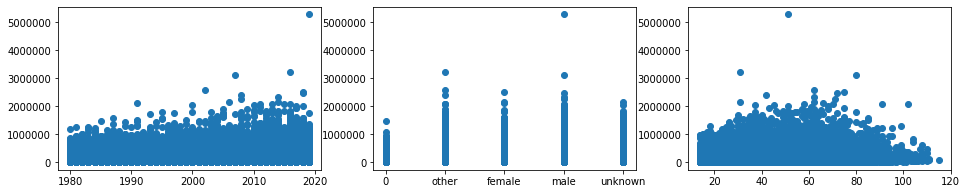

In [22]:
## Visualising

plt.figure(figsize=(16,3))

plt.subplot(131)
plt.scatter(x = Raw['Year of Record'], y = Raw['Income in EUR'])
plt.subplot(132)
plt.scatter(x = Raw['Gender'], y = Raw['Income in EUR'])
plt.subplot(133)
plt.scatter(x = Raw['Age'], y = Raw['Income in EUR'])
# plt.subplot(111)
# plt.scatter(x = Raw['Country'], y = Raw['Income in EUR'])
plt.show()

In [29]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(Raw['Income in EUR']))
print(z)
print(z.shape)
count = []
index = []
for i in range(len(z)):
    if z[i] > 2:
        count.append(z[i])
        index.append(i)
        
dropped = Raw.drop(index)

[0.32163766 0.12157727 0.32555287 ... 1.20651194 0.06119611 0.24480686]
(111993,)


(107157, 10)


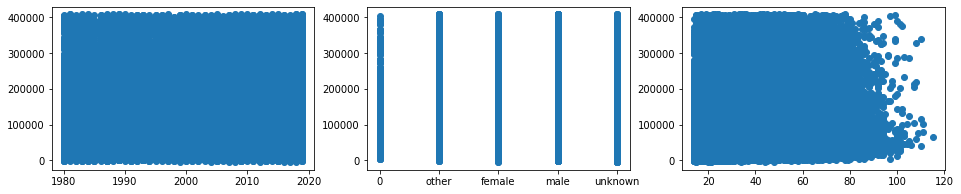

In [33]:
print(dropped.shape)
    
plt.figure(figsize=(16,3))

plt.subplot(131)
plt.scatter(x = dropped['Year of Record'], y = dropped['Income in EUR'])
plt.subplot(132)
plt.scatter(x = dropped['Gender'], y = dropped['Income in EUR'])
plt.subplot(133)
plt.scatter(x = dropped['Age'], y = dropped['Income in EUR'])
# plt.subplot(111)
# plt.scatter(x = Raw['Country'], y = Raw['Income in EUR'])
plt.show()